In [1]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient()
client = MongoClient('localhost', 27017)

In [3]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [4]:
dictlis = [#{'element':'Cu', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Cu', 'face':'111', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Ag', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Ag', 'face':'111', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Pt', 'face':'100', 'isvalid':'yes', 'unitlength':2},
#            {'element':'Pt', 'face':'111', 'isvalid':'yes', 'unitlength':2},
# #            {'element':'NiGa', 'mirror':'110', 'moved+':'no', 'moved':'no'},
# #            {'element':'CoPt3', 'mirror':'100', 'moved+':'no', 'moved':'no'},
#            {'element':'Pd', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
           {'element':'Pd', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Au', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Au', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Al', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Al', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Ni', 'face':'100', 'isvalid':'yes', 'unitlength':2},           
#            {'element':'Ni', 'face':'111', 'isvalid':'yes', 'unitlength':2},           
          ]

In [5]:
df = []
dfpred = []

for i in range(len(dictlis)):
    df.append(pd.DataFrame(list(collection.find(dictlis[i]))))
    dfpred.append(df[i][df[i]['numberofads'] > 1])

for i in range(len(dfpred)):
    dfpred[i] = dfpred[i].reset_index()

In [6]:
### Exclude coverage > 1.0 ###
for i in range(len(dfpred)):
    dfpred[i] = dfpred[i][dfpred[i]['coverage'] <= 1.0]

In [7]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
covset

[[0.5, 0.75, 1.0]]

### Predict ####

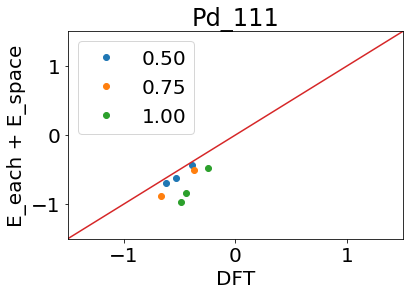

In [15]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        aveadsE_suratom = np.array(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['aveadsE/suratom'])
        E_residue = np.array(dfpred[i][dfpred[i]['coverage'] == covset[i][j]]['E_residue'])
        E_prepred = aveadsE_suratom - E_residue
        if calcElis == []:
            continue
        if xmin > np.min(calcElis):
            xmin = np.min(calcElis)
        if xmax < np.max(calcElis):
            xmax = np.max(calcElis)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
plt.show()

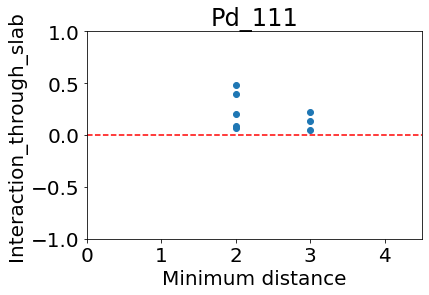

In [17]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 4.5
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i]['minimum_distance'], dfpred[i]['E_residue'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way

    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Minimum distance')
    ax.set_ylabel('Interaction_through_slab')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

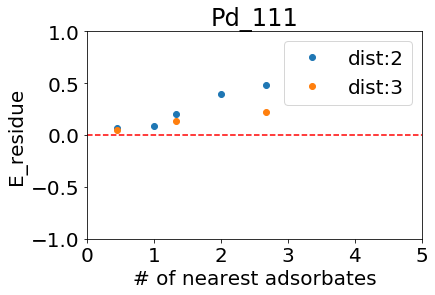

In [25]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20

xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'])
# plt.savefig('')
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

In [62]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression(fit_intercept=False)

def linearfit(X, y):
    Lin.fit(X, y)
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

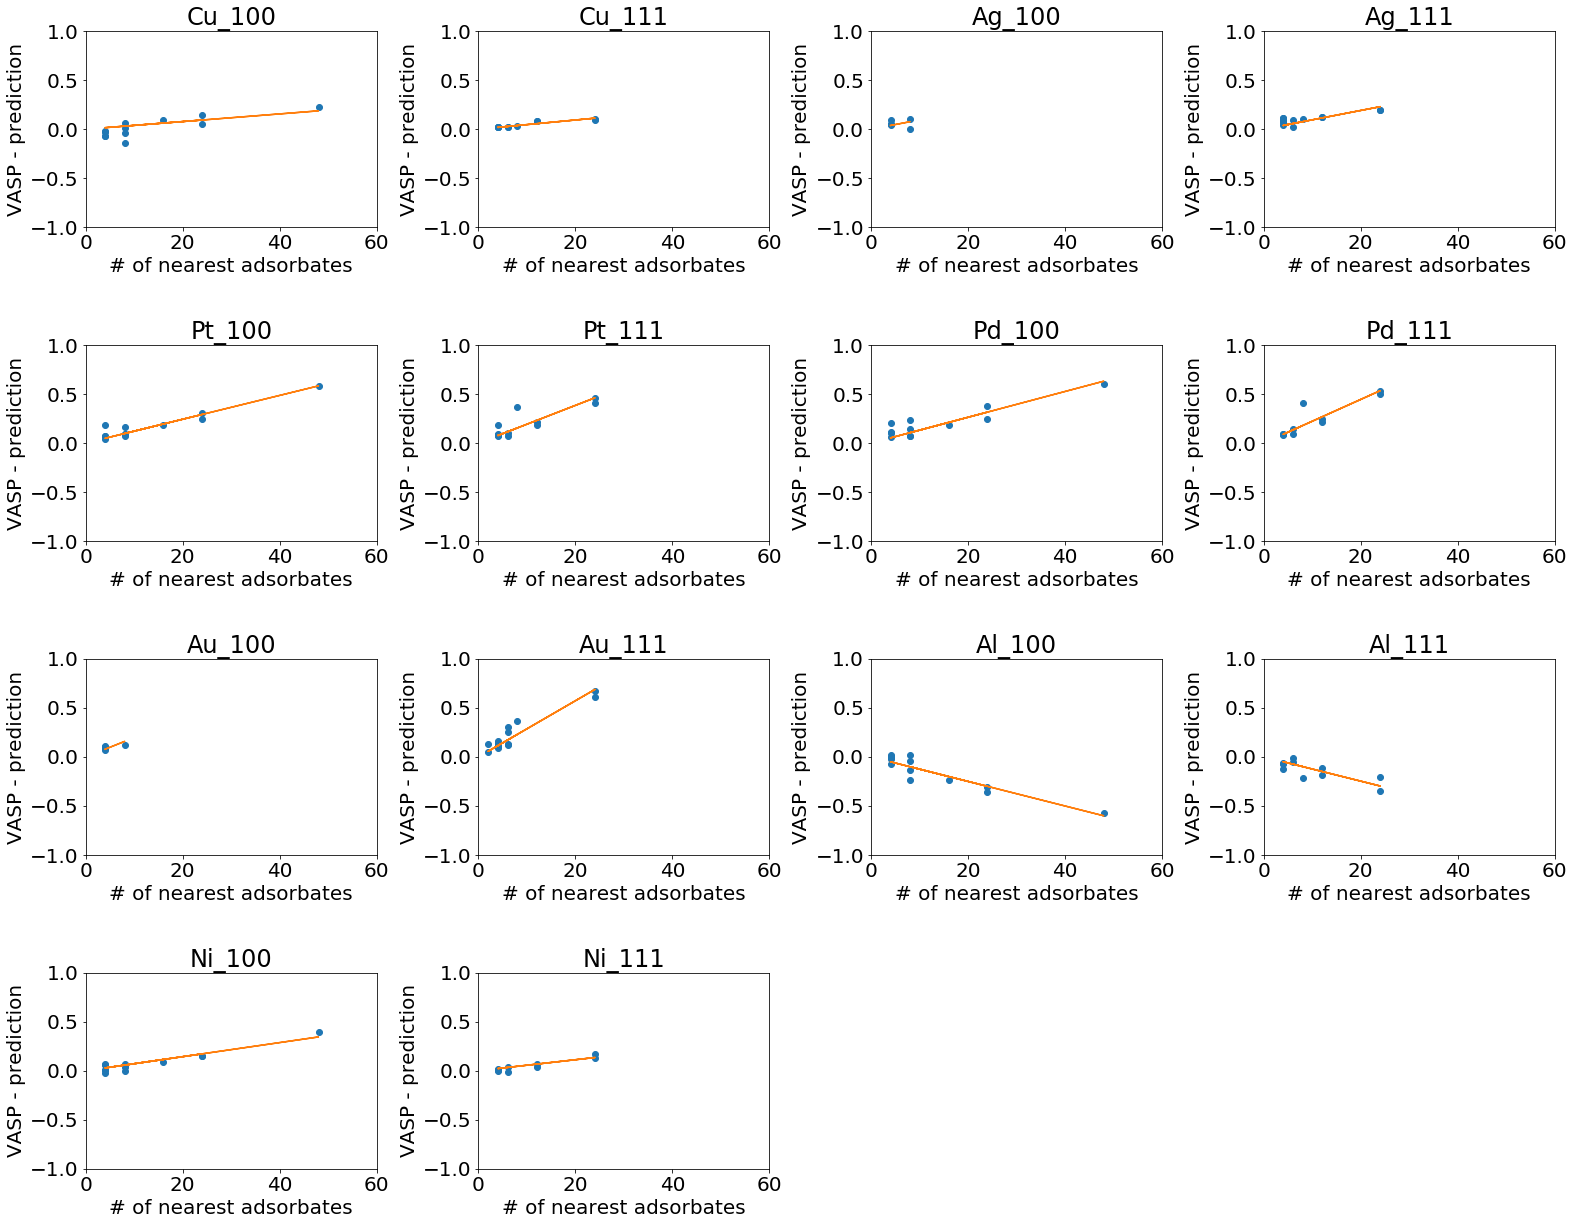

In [73]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
slopes2 = []

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X = np.array(dfpred[i][dfpred[i]['nbdist']==2]['#nbads'])
    y = np.array(dfpred[i][dfpred[i]['nbdist']==2]['VASP - prediction'])
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)
    slopes2.append(slope)

    ax.plot(X, y, 'o')
    ax.plot(X, fitres, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
#     plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

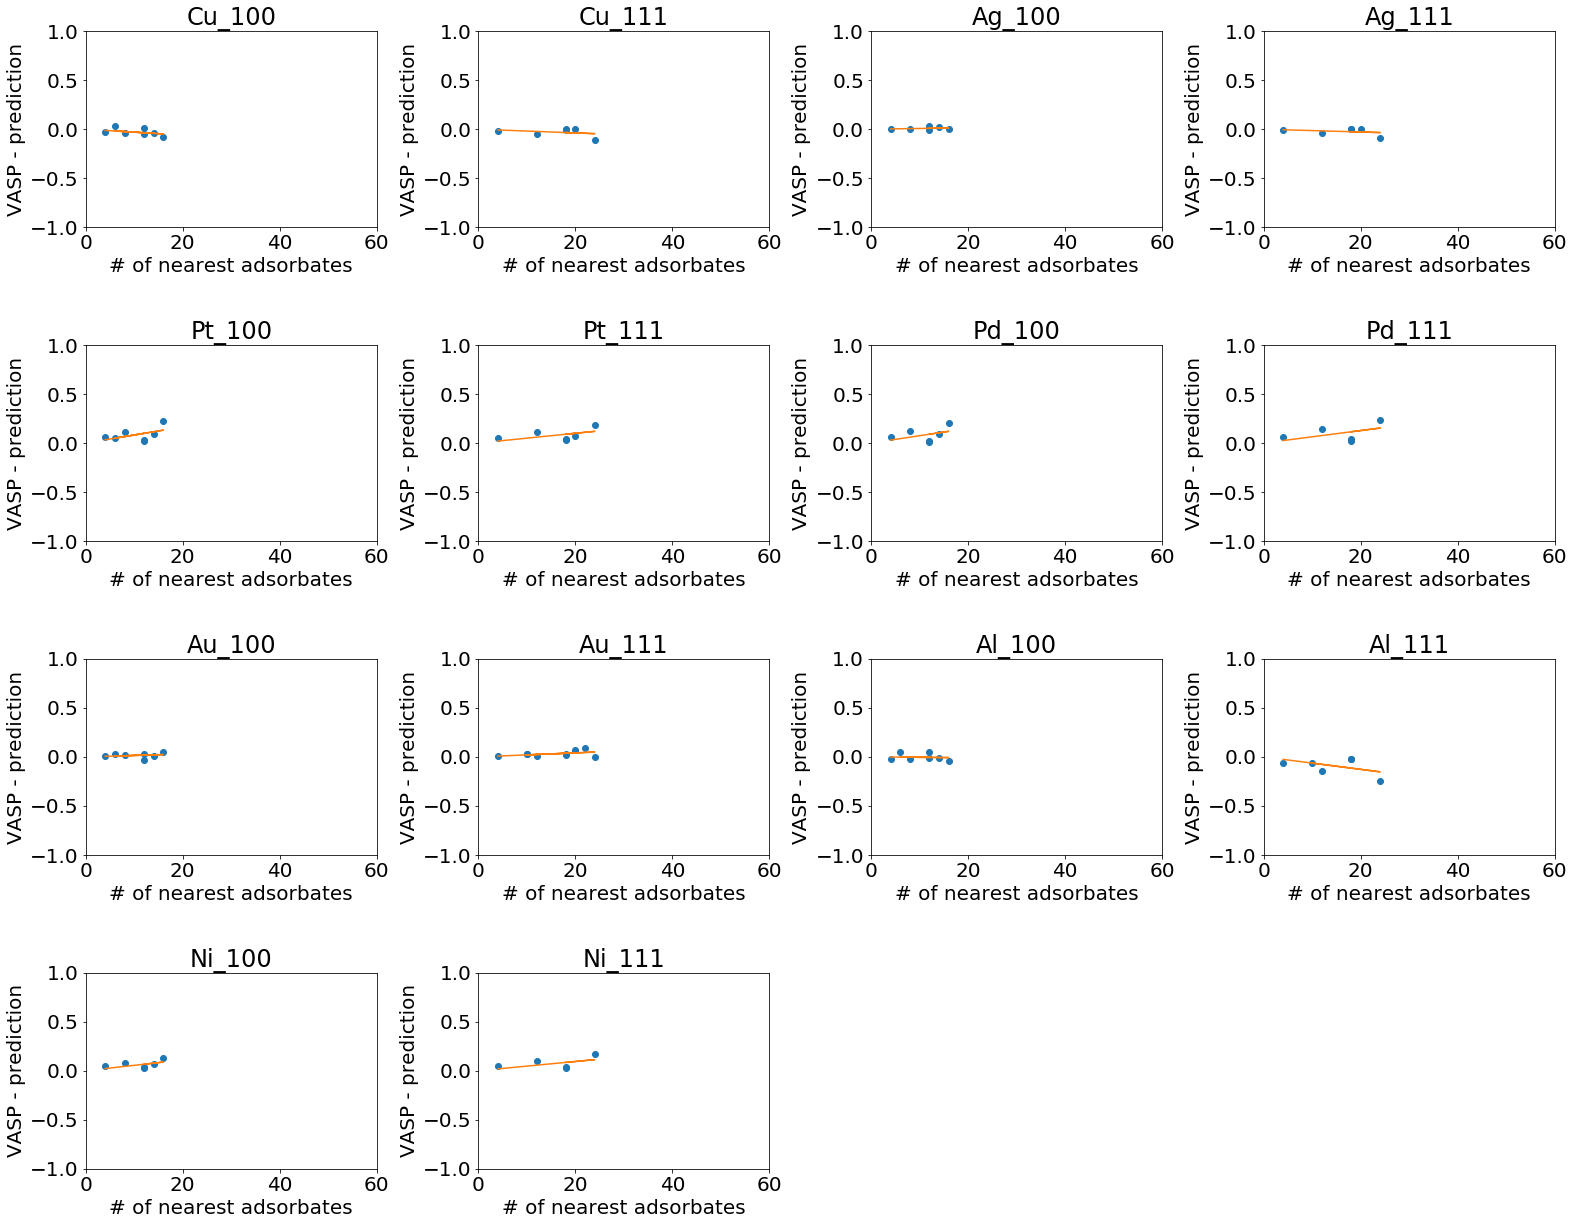

In [75]:
fig = plt.figure(figsize=(24,24))
plt.rcParams["font.size"] = 20
slopes3 = []

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X = np.array(dfpred[i][dfpred[i]['nbdist']==3]['#nbads'])
    y = np.array(dfpred[i][dfpred[i]['nbdist']==3]['VASP - prediction'])
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)
    slopes3.append(slope)

    ax.plot(X, y, 'o')
    ax.plot(X, fitres, '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('VASP - prediction')
#     plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [83]:
for item in slopes3:
    print(item)

[-0.00302335]
[-0.00189925]
[0.00073378]
[-0.00142921]
[0.00823093]
[0.00497808]
[0.00747731]
[0.00636418]
[0.00147808]
[0.00204164]
[-0.0004419]
[-0.00636254]
[0.00551048]
[0.00471202]
